In [1]:
import os
import torch
import numpy as np
import torchvision
import pandas as pd
import seaborn as sn
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix
from torch.utils.tensorboard import SummaryWriter

%matplotlib inline

In [2]:
class YourModel(nn.Module):
    def __init__(self):
        super(YourModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        nn.init.xavier_normal_(self.layer1[0].weight)
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        nn.init.xavier_normal_(self.layer2[0].weight)
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        nn.init.xavier_normal_(self.layer3[0].weight)
        self.layer4 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        nn.init.xavier_normal_(self.layer4[0].weight)
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        nn.init.xavier_normal_(self.layer5[0].weight)
        self.layer6 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        nn.init.xavier_normal_(self.layer6[0].weight)
        
        self.layer7 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        nn.init.xavier_normal_(self.layer7[0].weight)
        self.layer8 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        nn.init.xavier_normal_(self.layer8[0].weight)
        
        self.fc1 = nn.Linear(7 * 7 * 256, 1024)
        self.dr1 = nn.Dropout(p = 0.25)
        nn.init.xavier_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(1024, 10)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = out.reshape(out.size(0), -1) # flatten layer
        out = F.relu(self.fc1(out))
        out = self.dr1(out)
        out = self.fc2(out)
        return out

model = YourModel()

In [3]:
batch_size = 64
n_epochs = 10

is_cpu_available = torch.cuda.is_available()

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
#optimizer = optim.SGD(model.parameters(), lr=0.0003, momentum=0.95, weight_decay=0.0001)
criteria = nn.CrossEntropyLoss()

In [4]:
train_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
val_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
test_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

train_dataset = ImageFolder('./dataset_ucf_video_keyframe/train', train_transforms)
val_dataset = ImageFolder('./dataset_ucf_video_keyframe/val', val_transforms)
test_dataset = ImageFolder('./dataset_ucf_video_keyframe/test', test_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=32, num_workers=4, shuffle=False)
val_loader = DataLoader(dataset=test_dataset, batch_size=32, num_workers=4, shuffle=False)

classes = ['Archery', 'Basketball', 'Biking', 'Billiards', 'Bowling', 'BreastStroke', 'Hammering', 'IceDancing', 'Kayaking', 'Skiing']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


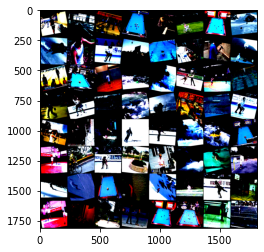

In [5]:
data_iter = iter(train_loader)
images, _ = data_iter.next()

grid_imgs = torchvision.utils.make_grid(images)
np_img = grid_imgs.numpy()
plt.imshow(np.transpose(np_img, (1, 2, 0)))
plt.show()

In [6]:
model.train()

if is_cpu_available:
    model.cuda()
    criteria.cuda()

losses_epoch_train = []
accuracy_epoch_train = []

losses_epoch_val = []
accuracy_epoch_val = []

writer = SummaryWriter()

# Training loop
for epoch in range(n_epochs):
    total = 0
    epoch_loss = 0
    epoch_correct = 0
    for ix, data in enumerate(train_loader):
        model.zero_grad()
        
        img, label = data
        if is_cpu_available:
            img = img.cuda()
            label = label.cuda()

        # Forward pass
        outputs = model.forward(img)
        loss = criteria(outputs, label)

        # Prevent gradient addition
        optimizer.zero_grad()

        # Gradient calculation
        loss.backward()

        # Optimization
        optimizer.step()

        # Train loss for iter
        epoch_loss += loss.item()

        # Train accuracy for iter
        _, predictions = torch.max(outputs.data, 1)
        correct_pediction = (predictions == label).sum()

        epoch_correct += correct_pediction
        total += len(label)
        
    losses_epoch_train.append(epoch_loss / len(train_loader))
    accuracy_epoch_train.append(epoch_correct / total)

    writer.add_scalars('loss', {'train loss': epoch_loss / len(train_loader)}, epoch)
    writer.add_scalars('acc', {'train acc': epoch_correct / total}, epoch)
    
    print('Epoch: {} - Train Loss: {} - Train Accuracy: {}'.format(epoch, epoch_loss / len(train_loader), epoch_correct / total))          

    with torch.no_grad():
        model.eval()

        total = 0
        epoch_loss = 0
        epoch_correct = 0
        # Measure the performance in validation set.
        for ix, data in enumerate(val_loader):
            img, label = data

            if is_cpu_available:
                img = img.cuda()
                label = label.cuda()

            # Test forward
            outputs = model.forward(img)
            loss = criteria(outputs, label)

            # Test loss for iter
            epoch_loss += loss.item()

            # Train accuracy for iter
            _, predictions = torch.max(outputs.data, 1)
            correct_pediction = (predictions == label).sum()

            epoch_correct += correct_pediction
            total += len(label)
            
        losses_epoch_val.append(epoch_loss / len(val_loader))
        accuracy_epoch_val.append(epoch_correct / total)

        writer.add_scalars('loss', {'val loss': epoch_loss / len(val_loader)}, epoch)
        writer.add_scalars('acc', {'val acc': epoch_correct / total}, epoch)

        print('Epoch: {} - Val Loss: {} - Val Accuracy: {}'.format(epoch, epoch_loss / len(val_loader), epoch_correct / total))          

    model.train()
    
writer.close()

Epoch: 0 - Train Loss: 0.7157127619893463 - Train Accuracy: 0.750708818435669
Epoch: 0 - Val Loss: 0.598621744189115 - Val Accuracy: 0.826214075088501
Epoch: 1 - Train Loss: 0.2332538137741295 - Train Accuracy: 0.9266108870506287
Epoch: 1 - Val Loss: 0.47173022913949225 - Val Accuracy: 0.8732014298439026
Epoch: 2 - Train Loss: 0.13418678333791195 - Train Accuracy: 0.9579253196716309
Epoch: 2 - Val Loss: 0.4843636248484577 - Val Accuracy: 0.8986061215400696
Epoch: 3 - Train Loss: 0.0975905935521479 - Train Accuracy: 0.9707474708557129
Epoch: 3 - Val Loss: 0.44871718953045264 - Val Accuracy: 0.9127697944641113
Epoch: 4 - Train Loss: 0.06297448590980391 - Train Accuracy: 0.981636643409729
Epoch: 4 - Val Loss: 0.47939902898058134 - Val Accuracy: 0.9172661900520325
Epoch: 5 - Train Loss: 0.04621881710886649 - Train Accuracy: 0.9863402247428894
Epoch: 5 - Val Loss: 0.5709649453513279 - Val Accuracy: 0.90265291929245
Epoch: 6 - Train Loss: 0.04650591774709492 - Train Accuracy: 0.9848582744598

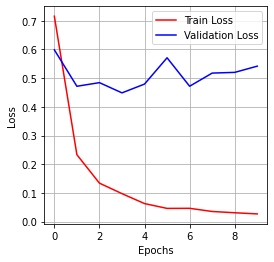

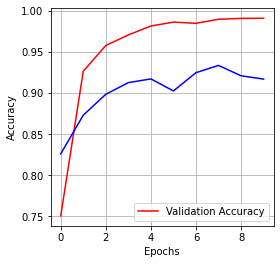

In [7]:
fig, ax = plt.subplots(figsize=(4, 4))
plt.plot(losses_epoch_train , color='r')
plt.plot(losses_epoch_val, color='b')
plt.legend(["Train Loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
ax.grid(True)

fig, ax = plt.subplots(figsize=(4, 4))
plt.plot(accuracy_epoch_train , color='r')
plt.plot(accuracy_epoch_val, color='b')
plt.legend(["Validation Accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
ax.grid(True)

Test Accuracy: % 0.9482758641242981 


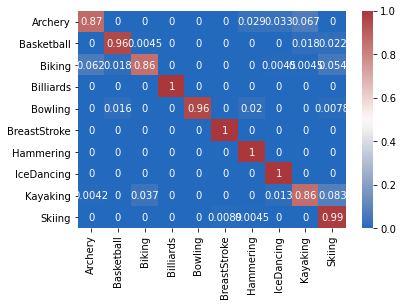

In [8]:
model.eval()

targets = []
predicts = []

with torch.no_grad():
    total = 0
    correct_prediction = 0
    for data in test_loader:
        img, label = data
        
        if is_cpu_available:
            img = img.cuda()
            label = label.cuda()
        
        outputs = model.forward(img)

        _, predictions = torch.max(outputs.data, 1)
        correct_prediction += (predictions == label).sum()
        
        total += len(label)
        
        preds = predictions.detach().cpu().numpy()
        labels = label.detach().cpu().numpy()
        
        for i in range(len(preds)):
            targets.append(labels[i])
            predicts.append(preds[i])

    print('Test Accuracy: % {} '.format(correct_prediction / total))
    
    matrix = confusion_matrix(targets, predicts, normalize = 'true')
    sn.heatmap(matrix, annot=True, cmap = sn.color_palette("vlag", as_cmap=True), xticklabels=classes, yticklabels=classes)